# Librerias

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from math import pi

In [9]:
from math import pi

# Cultivo

In [2]:

data = {
    'País': ['Bolivia', 'Colombia', 'Peru', 'Afganistán', 'Myanmar','Laos', 'Mexico'],
    'Coca': [26000, 119794.83, 58499.21, None, None, None, None],
    'Opio': [None, 408.76, None, 187414.29, 43223.08, 4443.38, 20.000]
}

df_cultivo = pd.DataFrame(data)

In [3]:
df_cultivo.head()

,País,Coca,Opio
0,Bolivia,26000.00,NaN
1,Colombia,119794.83,408.76
2,Peru,58499.21,NaN
3,Afganistán,NaN,187414.29
4,Myanmar,NaN,43223.08


<Figure size 1000x600 with 0 Axes>

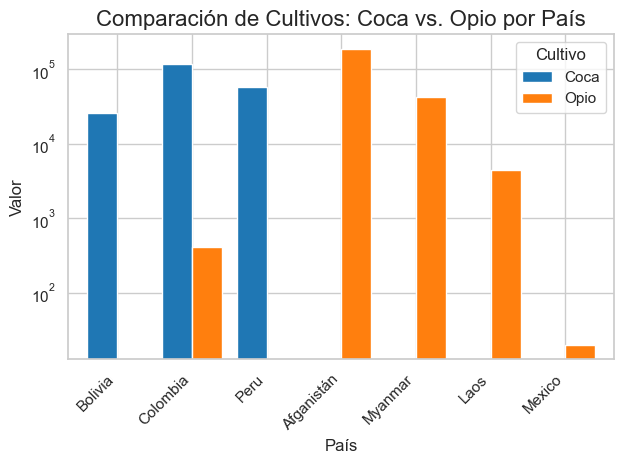

In [4]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))


df_cultivo.set_index('País')[['Coca', 'Opio']].plot(kind='bar', width=0.8, logy=True, color=['#1f77b4', '#ff7f0e'])

plt.title('Comparación de Cultivos: Coca vs. Opio por País', fontsize=16)
plt.xlabel('País', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cultivo', labels=['Coca', 'Opio'])

plt.tight_layout()
plt.show()

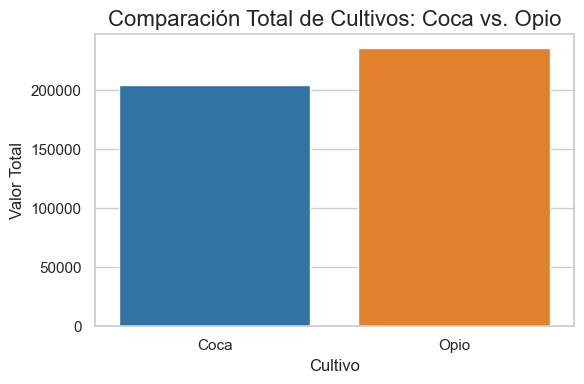

In [5]:
total_coca = df_cultivo['Coca'].sum()
total_opio = df_cultivo['Opio'].sum()

# Crear un DataFrame con los totales
df_total = pd.DataFrame({'Cultivo': ['Coca', 'Opio'], 'Valor': [total_coca, total_opio]})

# Graficar
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))

# Graficar barras
sns.barplot(x='Cultivo', y='Valor', data=df_total, palette=['#1f77b4', '#ff7f0e'])

plt.title('Comparación Total de Cultivos: Coca vs. Opio', fontsize=16)
plt.xlabel('Cultivo', fontsize=12)
plt.ylabel('Valor Total', fontsize=12)

plt.tight_layout()
plt.show()

# Produccion

In [10]:
df_produccion = pd.read_csv('../data/produccion.csv')

In [14]:
df_produccion.head()

,País,Cocaína,Categoría_Cocaína,Opioides,Categoría_Opioides,Metanfetaminas,Categoría_Metanfetaminas
0,Alemania,1.0,MUY BAJA,1.0,MUY BAJA,38.0,ALTA
1,Argentina,287.0,ALTA,1.0,MUY BAJA,4.0,BAJA
2,Australia,10.0,BAJA,6.0,BAJA,308.0,ALTA
3,Austria,NaN,NaN,NaN,NaN,23.0,MEDIA
4,Belgica,22.0,MEDIA,2.0,MUY BAJA,NaN,NaN


In [43]:
df_produccion.describe()

,Cocaína,Opioides,Metanfetaminas
count,26.000000,19.000000,37.000000
mean,1199.153846,10.105263,148.432432
std,4818.560704,9.774654,487.680994
min,1.000000,1.000000,1.000000
25%,1.000000,2.500000,2.000000
50%,12.000000,8.000000,8.000000
75%,67.500000,14.000000,32.000000
max,24514.000000,40.000000,2806.000000


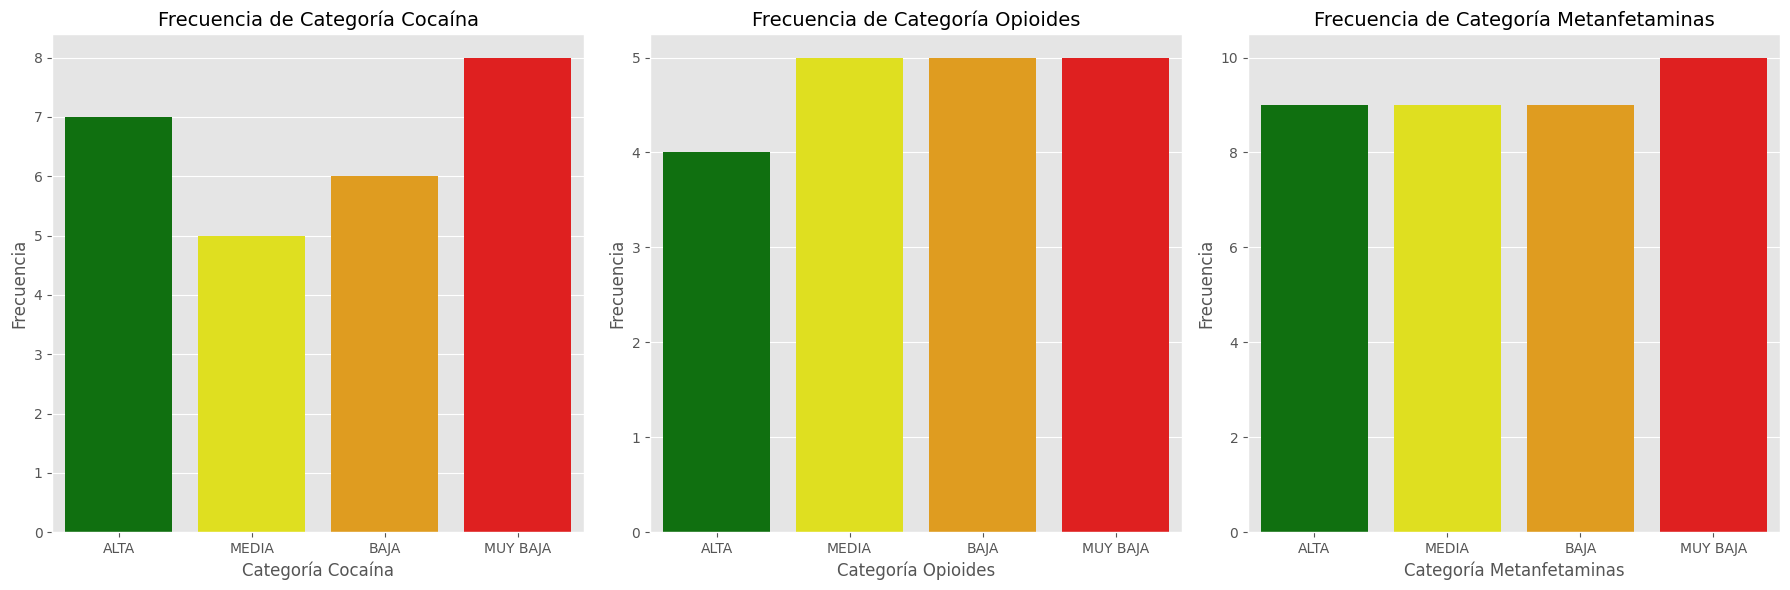

In [47]:
palette = {'MUY BAJA': 'red', 'BAJA': 'orange', 'MEDIA': 'yellow', 'ALTA': 'green'}

df_categories = df_produccion[['Categoría_Cocaína', 'Categoría_Opioides', 'Categoría_Metanfetaminas']]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(x='Categoría_Cocaína', data=df_categories, ax=axes[0], palette=palette, order=['ALTA', 'MEDIA', 'BAJA', 'MUY BAJA'])
axes[0].set_title('Frecuencia de Categoría Cocaína', fontsize=14)
axes[0].set_xlabel('Categoría Cocaína', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)

sns.countplot(x='Categoría_Opioides', data=df_categories, ax=axes[1], palette=palette, order=['ALTA', 'MEDIA', 'BAJA', 'MUY BAJA'])
axes[1].set_title('Frecuencia de Categoría Opioides', fontsize=14)
axes[1].set_xlabel('Categoría Opioides', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)

sns.countplot(x='Categoría_Metanfetaminas', data=df_categories, ax=axes[2], palette=palette, order=['ALTA', 'MEDIA', 'BAJA', 'MUY BAJA'])
axes[2].set_title('Frecuencia de Categoría Metanfetaminas', fontsize=14)
axes[2].set_xlabel('Categoría Metanfetaminas', fontsize=12)
axes[2].set_ylabel('Frecuencia', fontsize=12)

plt.tight_layout()
plt.show()

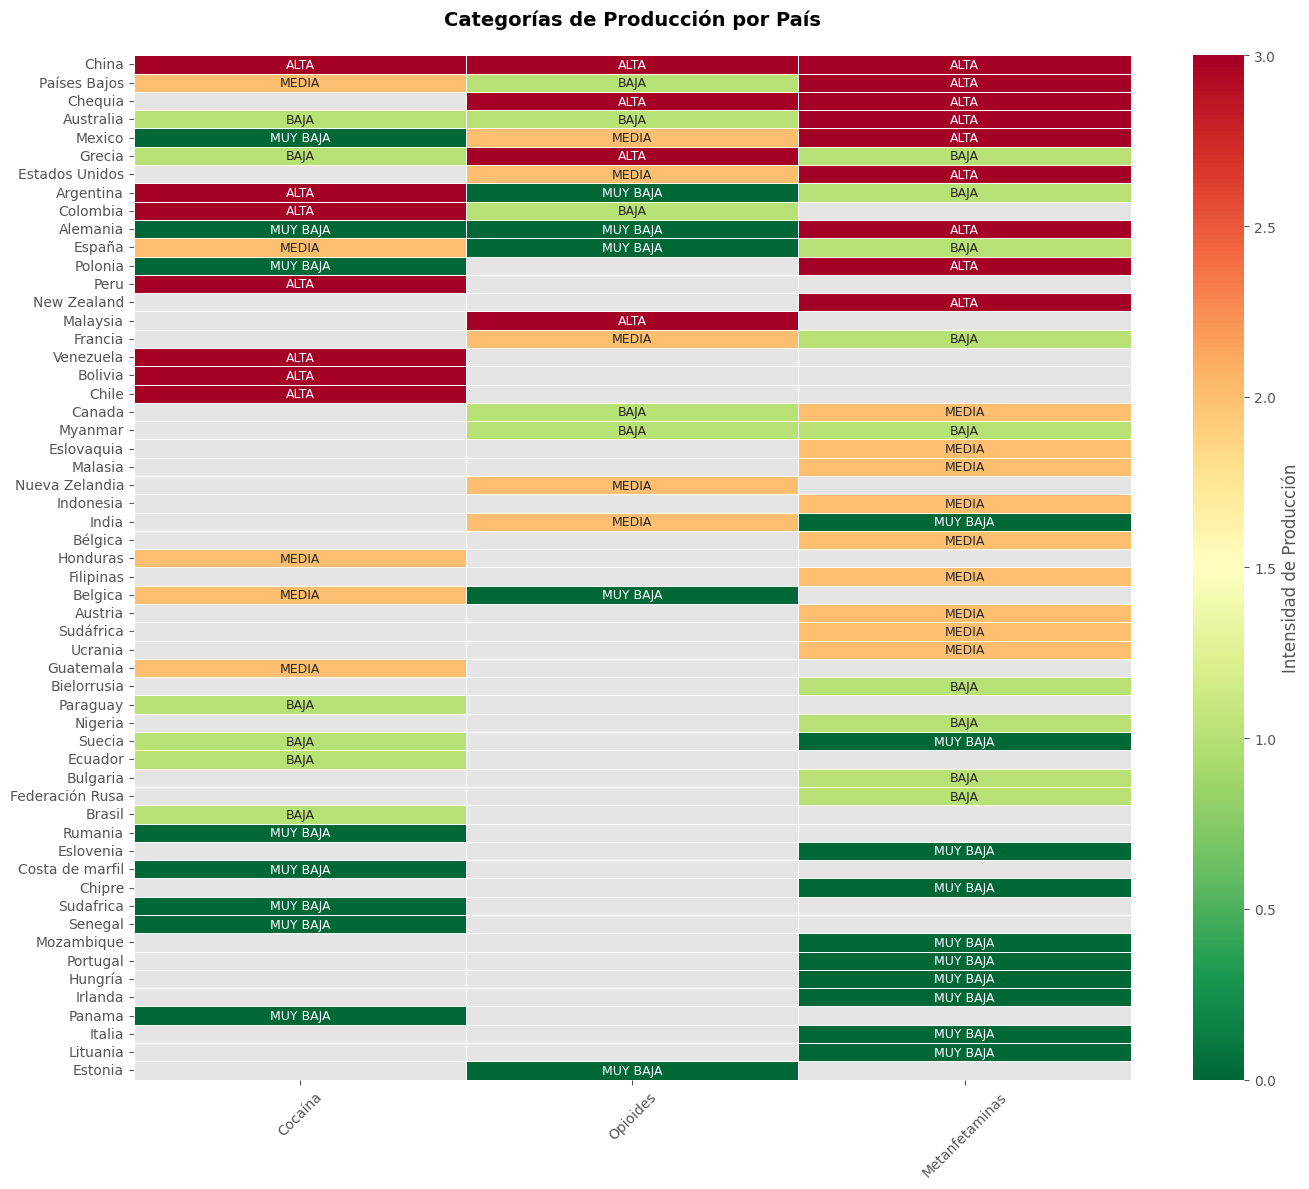

In [16]:
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_heatmap():
    categorias = df_produccion[['País', 'Categoría_Cocaína', 'Categoría_Opioides', 'Categoría_Metanfetaminas']].dropna(how='all')
    
    order = categorias.fillna('Z').apply(lambda x: x.map({'ALTA':3, 'MEDIA':2, 'BAJA':1, 'MUY BAJA':0})).sum(axis=1).sort_values(ascending=False).index
    categorias = categorias.iloc[order]
    
    heatmap_data = categorias[['Categoría_Cocaína', 'Categoría_Opioides', 'Categoría_Metanfetaminas']]\
        .apply(lambda x: x.map({'ALTA':3, 'MEDIA':2, 'BAJA':1, 'MUY BAJA':0, np.nan: np.nan}))
    
    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(heatmap_data, 
                    annot=categorias[['Categoría_Cocaína', 'Categoría_Opioides', 'Categoría_Metanfetaminas']],
                    cmap='RdYlGn_r', 
                    linewidths=0.5,
                    cbar_kws={'label': 'Intensidad de Producción'},
                    annot_kws={'fontsize':9},
                    fmt='')
    
    ax.set_yticklabels(categorias['País'], rotation=0)
    ax.set_xticklabels(['Cocaína', 'Opioides', 'Metanfetaminas'], rotation=45)
    plt.title('Categorías de Producción por País\n', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
plot_heatmap()

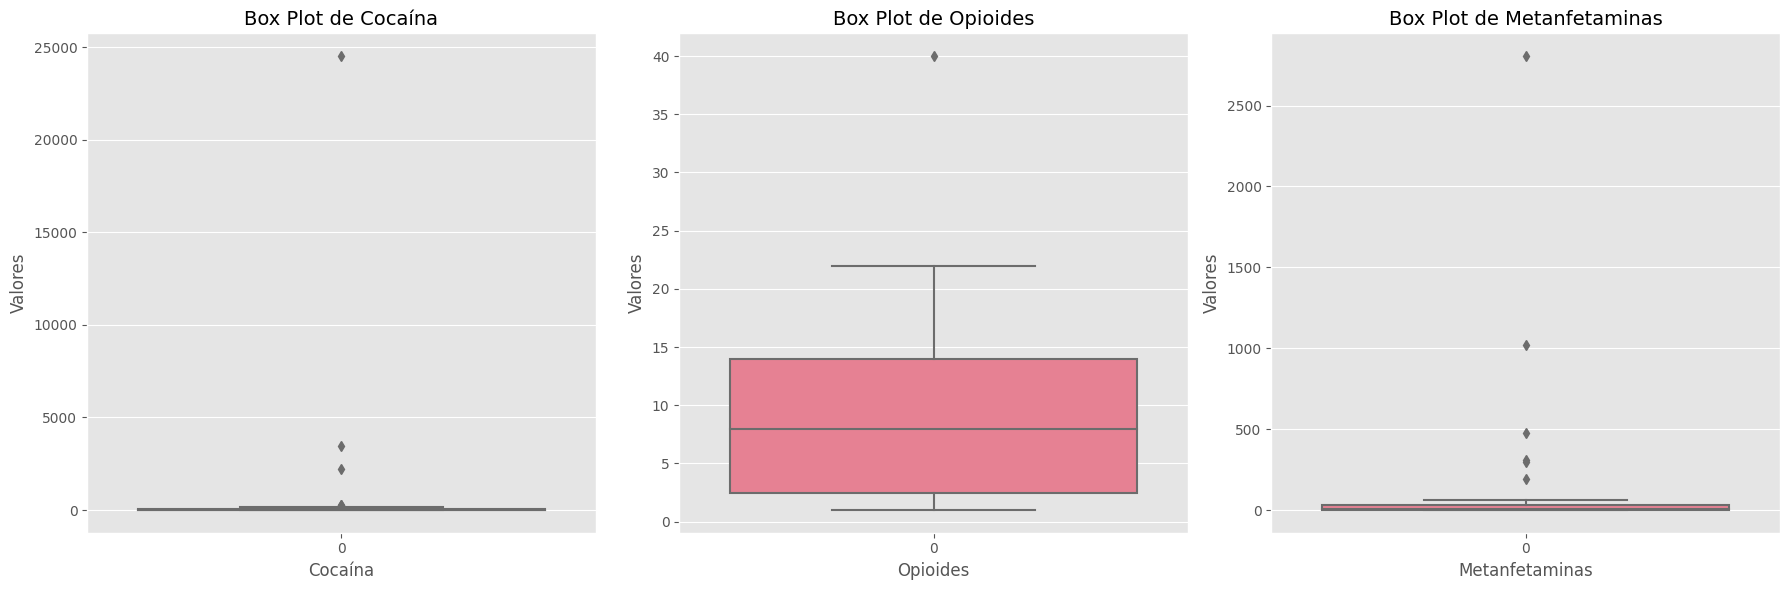

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(data=df_produccion['Cocaína'], ax=axes[0])
axes[0].set_title('Box Plot de Cocaína', fontsize=14)
axes[0].set_xlabel('Cocaína', fontsize=12)
axes[0].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_produccion['Opioides'], ax=axes[1])
axes[1].set_title('Box Plot de Opioides', fontsize=14)
axes[1].set_xlabel('Opioides', fontsize=12)
axes[1].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_produccion['Metanfetaminas'], ax=axes[2])
axes[2].set_title('Box Plot de Metanfetaminas', fontsize=14)
axes[2].set_xlabel('Metanfetaminas', fontsize=12)
axes[2].set_ylabel('Valores', fontsize=12)

plt.tight_layout()
plt.show()

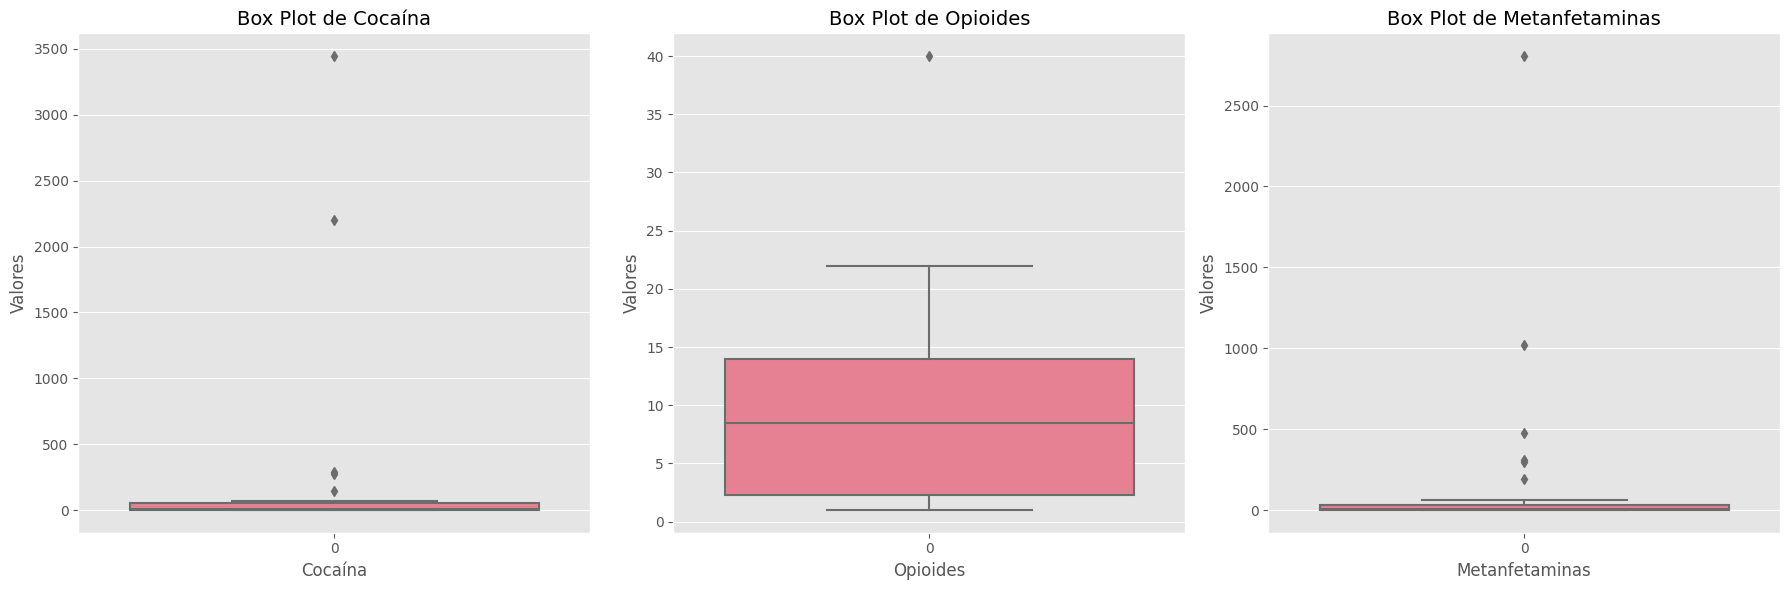

In [41]:
df_sin_colombia = df_produccion[df_produccion['País'] != 'Colombia']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(data=df_sin_colombia['Cocaína'], ax=axes[0])
axes[0].set_title('Box Plot de Cocaína', fontsize=14)
axes[0].set_xlabel('Cocaína', fontsize=12)
axes[0].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_sin_colombia['Opioides'], ax=axes[1])
axes[1].set_title('Box Plot de Opioides', fontsize=14)
axes[1].set_xlabel('Opioides', fontsize=12)
axes[1].set_ylabel('Valores', fontsize=12)

sns.boxplot(data=df_sin_colombia['Metanfetaminas'], ax=axes[2])
axes[2].set_title('Box Plot de Metanfetaminas', fontsize=14)
axes[2].set_xlabel('Metanfetaminas', fontsize=12)
axes[2].set_ylabel('Valores', fontsize=12)

plt.tight_layout()
plt.show()

In [33]:
df_prod_num[['País', 'Cocaína']].sort_values(by='Cocaína', ascending=False).head()

,País,Cocaína
15,Colombia,24514.0
6,Bolivia,3446.0
46,Peru,2202.0
1,Argentina,287.0
55,Venezuela,271.0


In [35]:
df_prod_num[['País', 'Metanfetaminas']].sort_values(by='Metanfetaminas', ascending=False).head()

,País,Metanfetaminas
21,Estados Unidos,2806.0
11,Chequia,1021.0
13,China,479.0
2,Australia,308.0
40,New Zealand,297.0


In [36]:
df_prod_num[['País', 'Opioides']].sort_values(by='Opioides', ascending=False).head()

,País,Opioides
36,Malaysia,40.0
26,Grecia,22.0
11,Chequia,19.0
13,China,19.0
37,Mexico,14.0


# Consumo

In [6]:
df_consumo = pd.read_csv('../data/consumo.csv')

In [7]:
df_consumo

,País,Cocaína,Categoría_Cocaína,Cannabis,Categoría_Cannabis,Metanfetaminas,Categoría_Metanfetaminas,Opioides,Categoría_Opioides
0,Albania,2.50,Alta,5.60,Media,0.10,Muy Baja,NaN,NaN
1,Alemania,1.03,Media,6.62,Media,1.15,Alta,0.36,Baja
2,Argelia,0.01,Muy baja,0.52,Muy baja,0.03,Muy Baja,NaN,NaN
3,Argentina,1.20,Media,5.67,Media,NaN,NaN,0.19,Muy baja
4,Australia,2.73,Alta,10.80,Alta,1.73,Alta,3.10,Alta
...,...,...,...,...,...,...,...,...,...
78,Turquía,0.05,Muy baja,0.84,Muy baja,0.02,Muy Baja,NaN,NaN
79,Túnez,0.10,Muy baja,3.97,Media,NaN,NaN,NaN,NaN
80,Ucrania,0.42,Baja,2.51,Baja,0.51,Media,NaN,NaN
81,Uruguay,2.00,Alta,10.73,Alta,0.11,Muy Baja,2.54,Alta


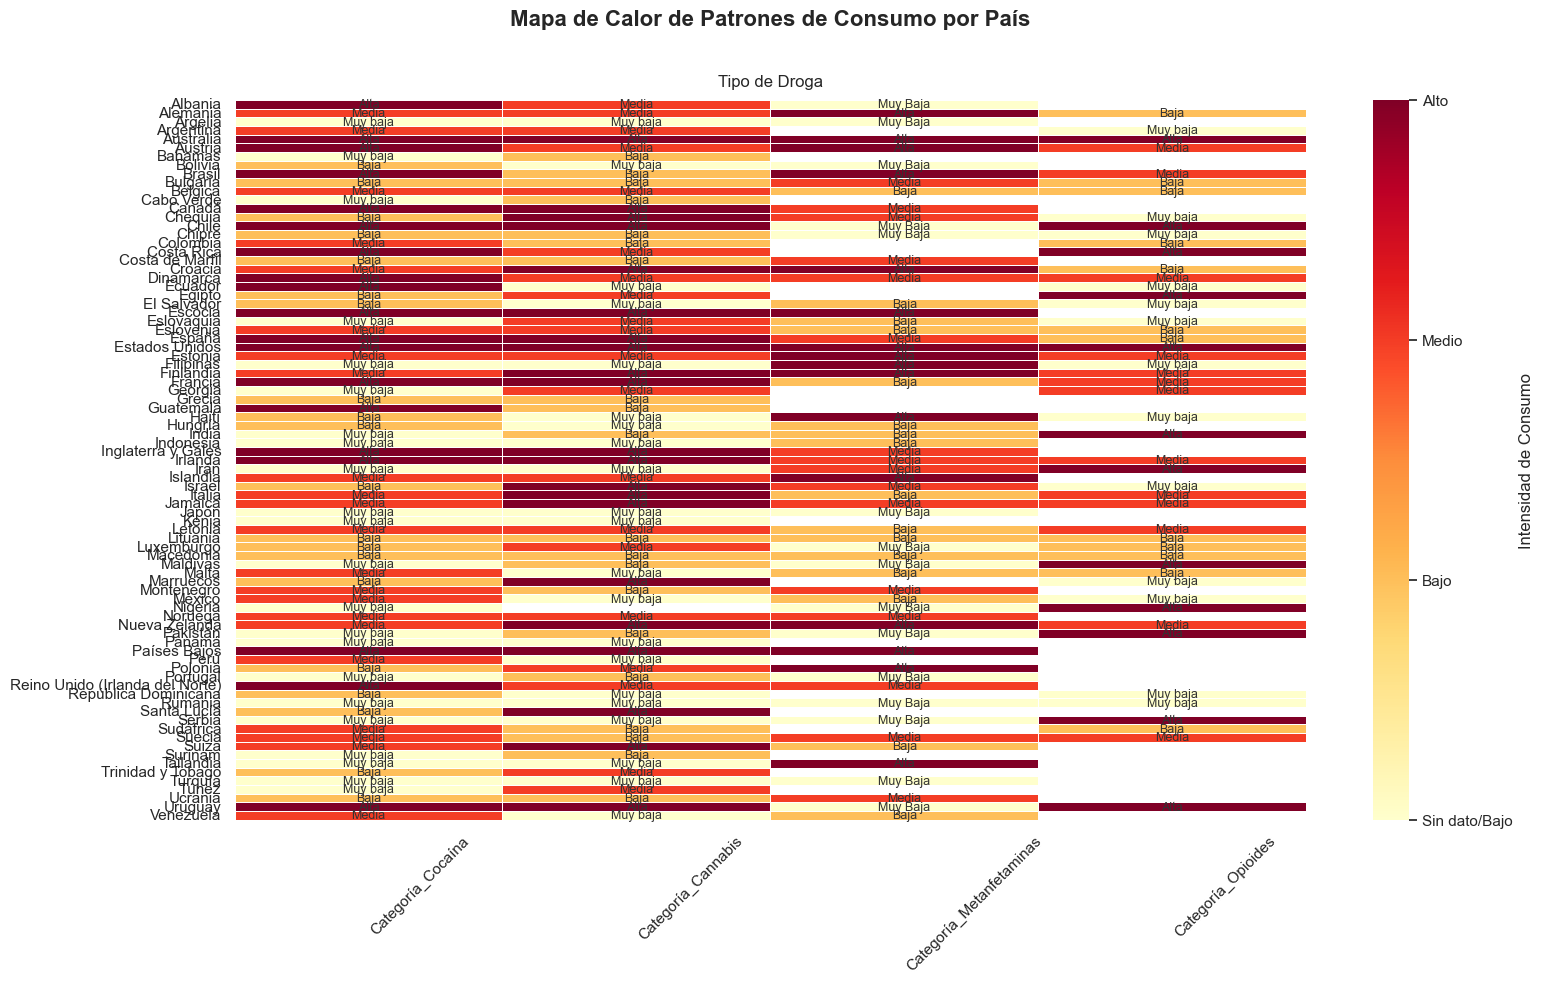

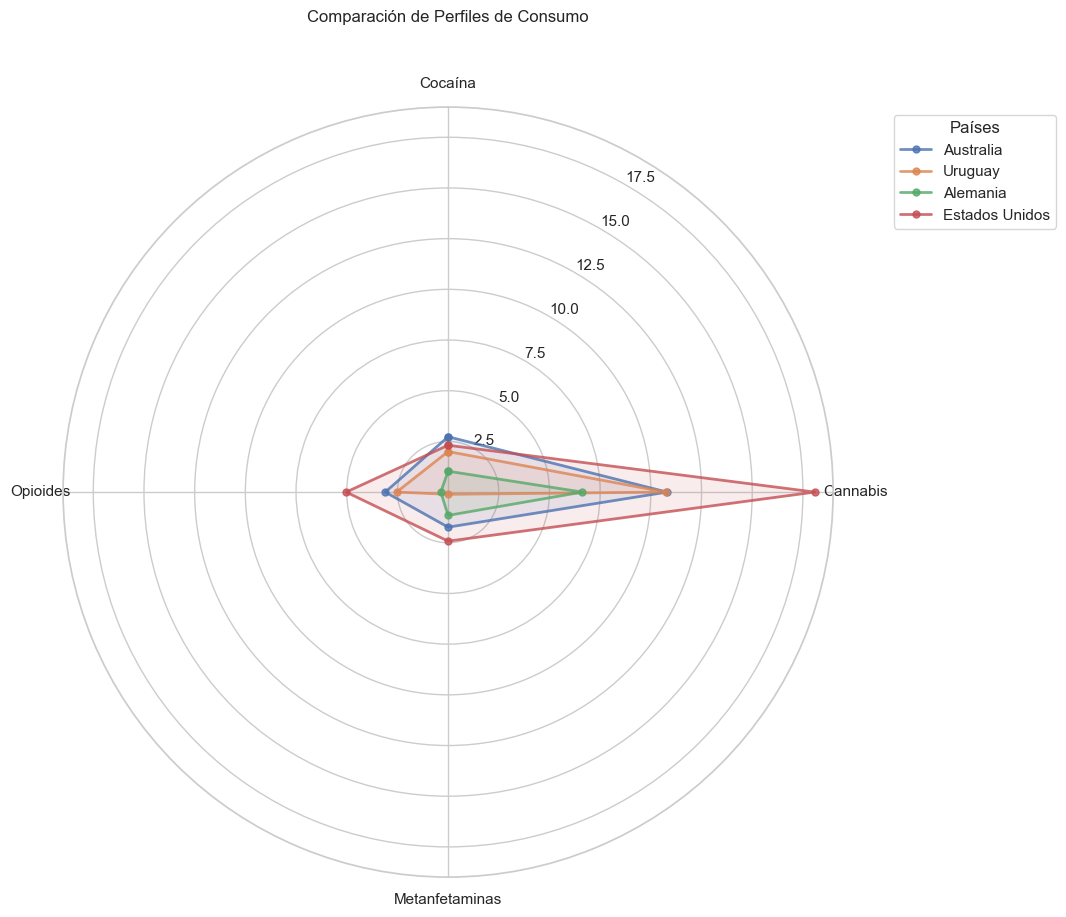

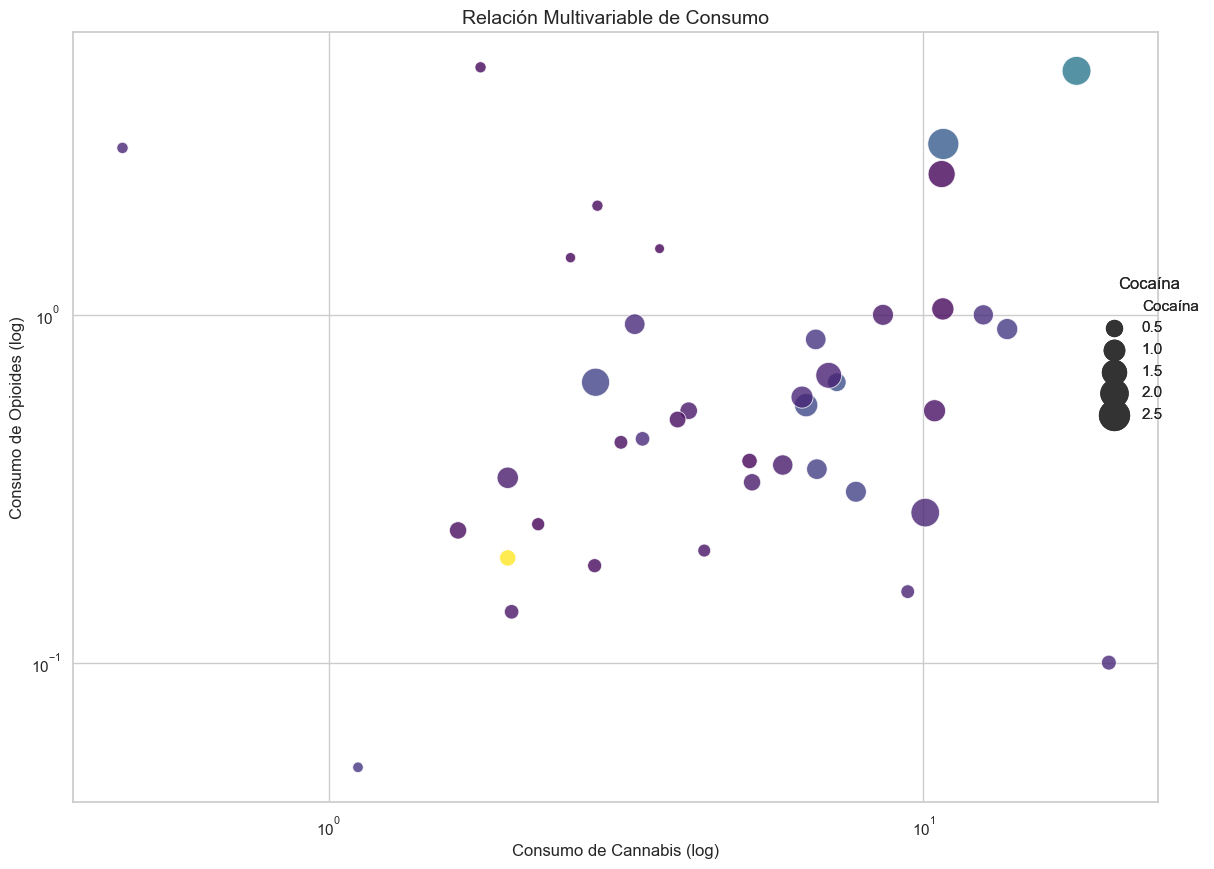

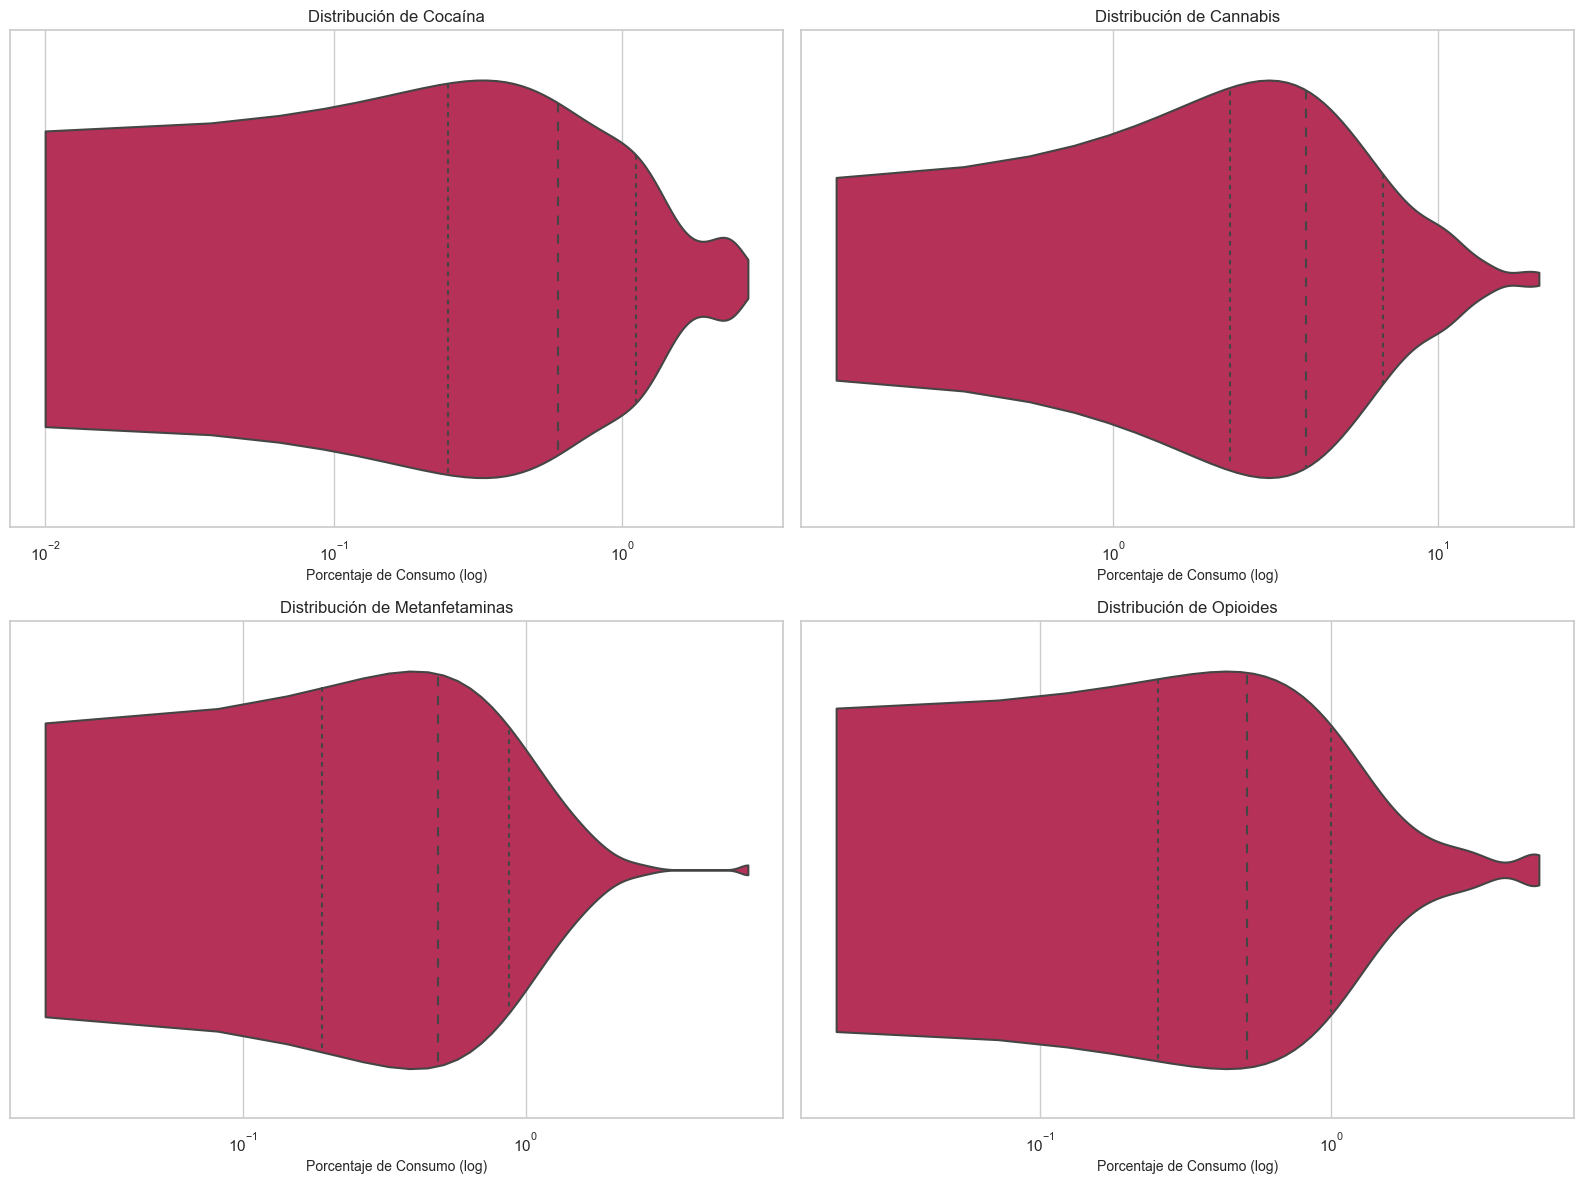

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Preprocesamiento correcto de datos
# Crear copia para no modificar el dataframe original
categorias = df_consumo[['Categoría_Cocaína', 'Categoría_Cannabis', 
                        'Categoría_Metanfetaminas', 'Categoría_Opioides']].copy()

# Mapeo completo y consistente (atención a mayúsculas y espacios)
orden_categorias = {
    'Alta': 3,
    'Media': 2,
    'Baja': 1,
    'Muy Baja': 0,  # Original tiene 'Muy Baja' con espacio y mayúscula
    'Muy baja': 0,  # Versión alternativa detectada en algunos registros
    'Sin dato': 0
}

# Aplicar mapeo columna por columna
numeric_cat = categorias.apply(lambda col: col.map(orden_categorias))

# 2. Generar heatmap con parámetros validados
plt.figure(figsize=(16, 10))
ax = sns.heatmap(
    numeric_cat,
    annot=categorias.replace({'Sin dato': ''}),  # Limpiar etiquetas
    cmap='YlOrRd',
    linewidths=0.5,
    cbar_kws={'label': 'Intensidad de Consumo'},
    yticklabels=df_consumo['País'],
    fmt='',  # Formato textual
    annot_kws={'fontsize': 9, 'color': '#333333'},
    vmin=0,  # Establecer límites claros
    vmax=3
)

# 3. Personalización avanzada
ax.set_title('Mapa de Calor de Patrones de Consumo por País\n', 
            fontsize=16, fontweight='bold')
ax.set_xlabel('\nTipo de Droga', fontsize=12, labelpad=10)
ax.xaxis.set_label_position('top') 
plt.xticks(rotation=45, ha='left')

# 4. Barra de color personalizada
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(['Sin dato/Bajo', 'Bajo', 'Medio', 'Alto'])

plt.tight_layout()
plt.show()

# 2. Radar Chart comparativo (países seleccionados)
def radar_chart_comparativo(paises):
    categorias = ['Cocaína', 'Cannabis', 'Metanfetaminas', 'Opioides']
    N = len(categorias)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    for pais in paises:
        datos = df_consumo[df_consumo['País'] == pais][categorias].values[0]
        datos = np.append(datos, datos[0])
        
        angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
        angles += angles[:1]
        
        ax.plot(angles, datos, marker='o', markersize=5, linewidth=2,
               label=pais, alpha=0.8)
        ax.fill(angles, datos, alpha=0.1)
    
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categorias)
    ax.set_rlabel_position(30)
    plt.legend(bbox_to_anchor=(1.3, 1), title='Países')
    plt.title('Comparación de Perfiles de Consumo', y=1.1)
    plt.show()

radar_chart_comparativo(['Australia', 'Uruguay', 'Alemania', 'Estados Unidos'])

# 3. Matriz de dispersión con burbujas
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    data=df_consumo,
    x='Cannabis',
    y='Opioides',
    size='Cocaína',
    hue='Metanfetaminas',
    sizes=(50, 500),
    palette='viridis',
    alpha=0.8
)

plt.xscale('log')
plt.yscale('log')
plt.title('Relación Multivariable de Consumo', fontsize=14)
plt.xlabel('Consumo de Cannabis (log)', fontsize=12)
plt.ylabel('Consumo de Opioides (log)', fontsize=12)

# Leyenda mejorada
h, l = scatter.get_legend_handles_labels()
plt.legend(h[1:5], l[1:5], 
          bbox_to_anchor=(1.05, 1), 
          title='Metanfetaminas',
          borderaxespad=0)

size_legend = plt.legend(h[5:], l[5:], 
                        bbox_to_anchor=(1.05, 0.7),
                        title='Cocaína',
                        frameon=False)
plt.gca().add_artist(size_legend)

# 4. Gráfico de violín mejorado para distribución de consumo
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
drogas = ['Cocaína', 'Cannabis', 'Metanfetaminas', 'Opioides']

for ax, droga in zip(axes.flatten(), drogas):
    sns.violinplot(data=df_consumo, 
                  x=droga, 
                  inner='quartile',
                  cut=0,
                  palette='rocket',
                  ax=ax)
    ax.set_xscale('log')
    ax.set_title(f'Distribución de {droga}', fontsize=12)
    ax.set_xlabel('Porcentaje de Consumo (log)', fontsize=10)

plt.tight_layout()
plt.show()

# Trafico

In [25]:
df_trafico = pd.read_csv('../data/trafico.csv')

In [26]:
df_trafico

,País,Cocaína,Cannabis,Metanfetaminas,Heroína
0,Sri Lanka,177609.980000,1731.53,4567.113736,145917.640000
1,Australia,159530.390000,NaN,85635.359116,142964.640000
2,Finlandia,94686.555524,5751.15,14874.141876,53374.333333
3,Palestina,75000.000000,4464.29,NaN,NaN
4,Moldavia,71174.380000,NaN,NaN,126448.890000
...,...,...,...,...,...
85,Catar,NaN,NaN,136314.067612,136314.070000
86,Bangladés,NaN,172.40,NaN,164051.000000
87,Azerbaiyán,NaN,3938.46,6000.000000,17688.680000
88,Arabia Saudita,NaN,6620.37,NaN,NaN


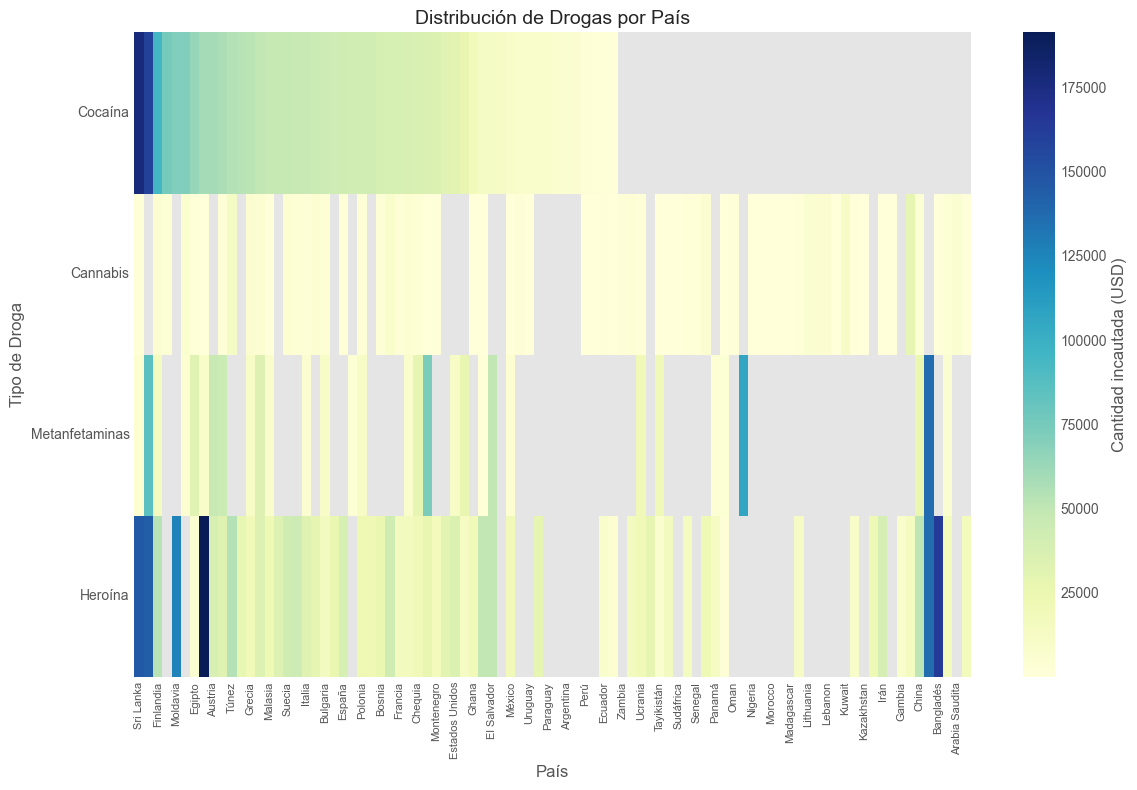

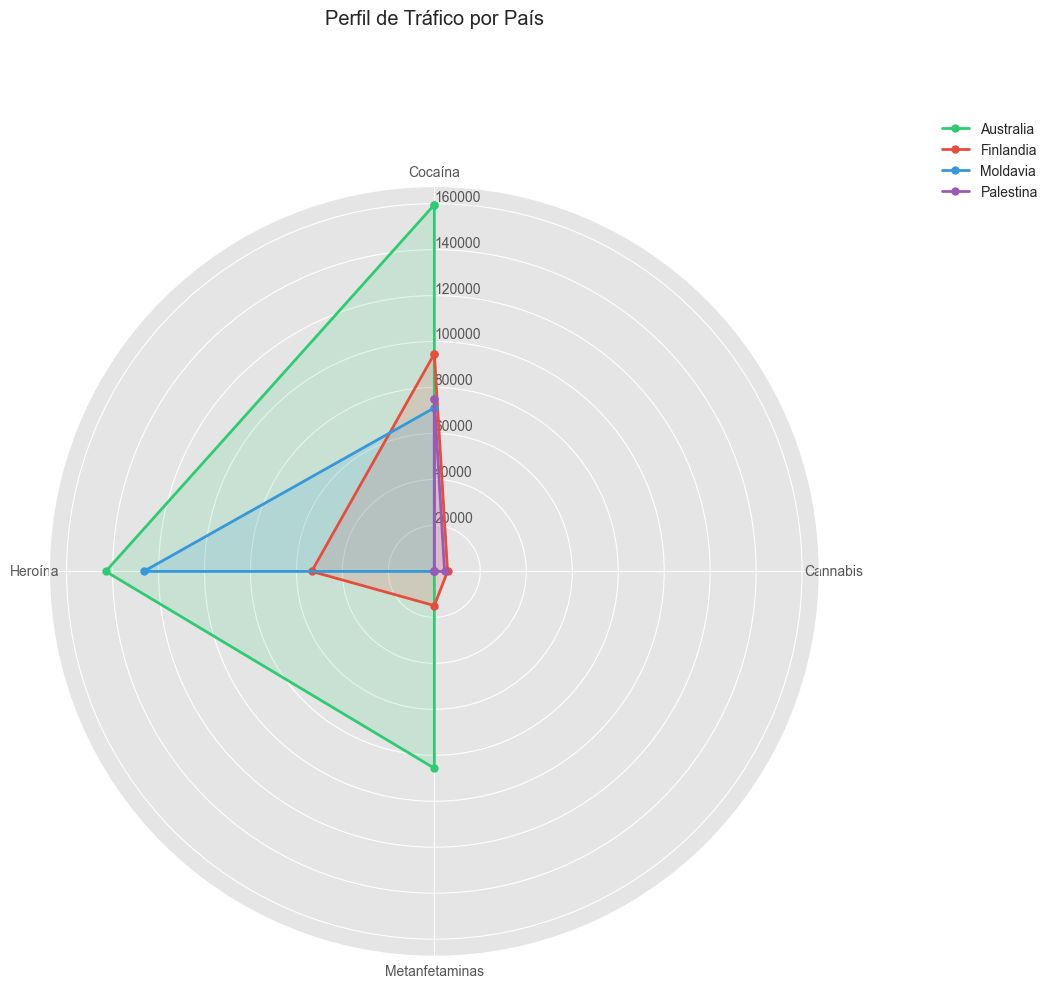

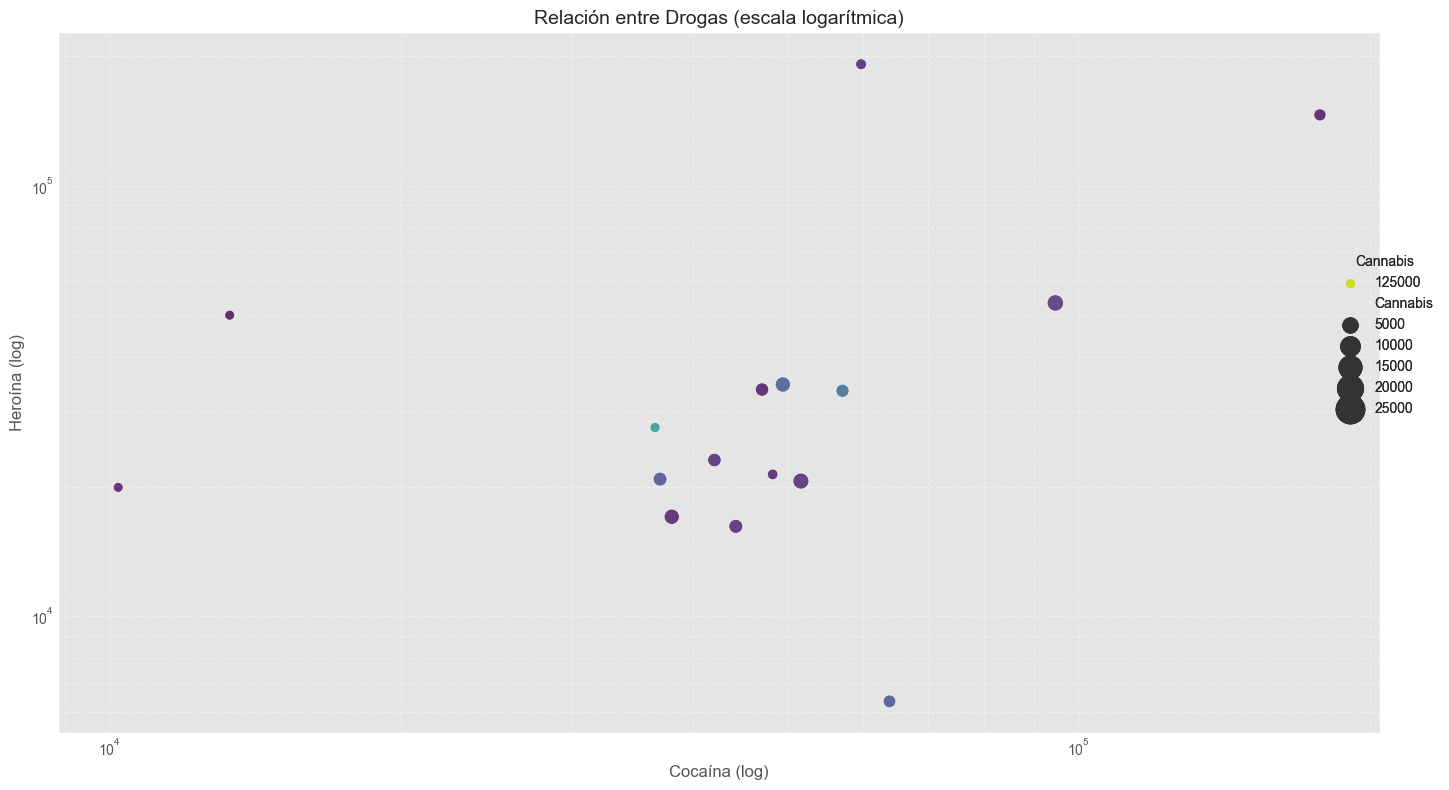

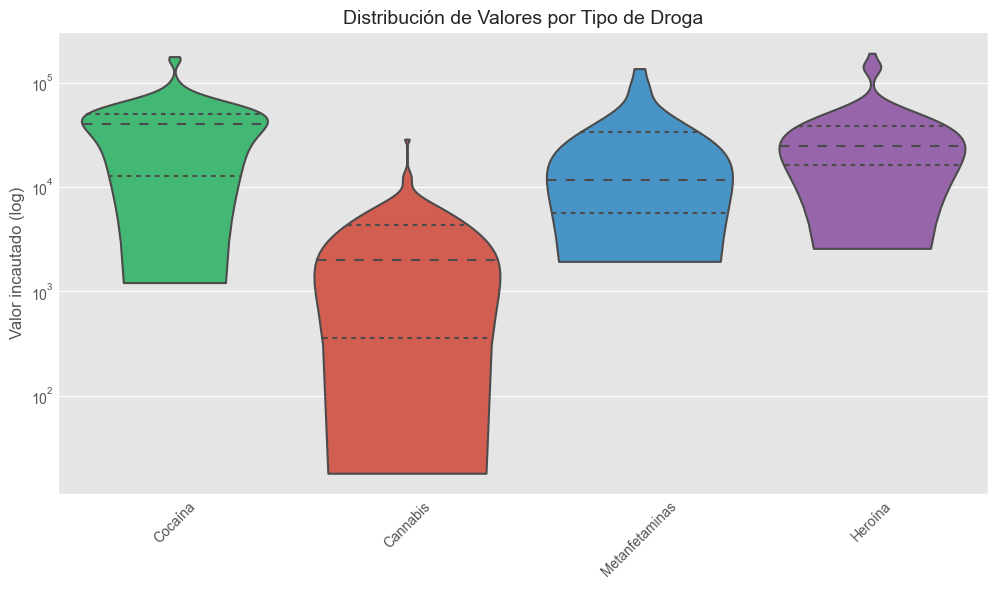

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración estética
plt.style.use('ggplot')
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6']
sns.set_palette(sns.color_palette(colors))

# 1. Heatmap de distribución por drogas
plt.figure(figsize=(12, 8))
heatmap_data = df_trafico.set_index('País').dropna(how='all')
sns.heatmap(heatmap_data.T, 
           cmap='YlGnBu',
           mask=heatmap_data.T.isnull(),
           cbar_kws={'label': 'Cantidad incautada (USD)'})
plt.title('Distribución de Drogas por País', fontsize=14)
plt.xlabel('País')
plt.ylabel('Tipo de Droga')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Radar chart para comparación multidroga
from math import pi

def plot_radar_chart(countries):
    categories = df_trafico.columns[1:]
    N = len(categories)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)
    
    for idx, country in enumerate(countries):
        values = df_trafico[df_trafico['País'] == country].iloc[:,1:].fillna(0).values[0]
        values = np.append(values, values[:1])
        
        angles = [n/float(N)*2*pi for n in range(N)]
        angles += angles[:1]
        
        ax.plot(angles, values, linewidth=2, linestyle='solid', 
               label=country, marker='o', markersize=5)
        ax.fill(angles, values, alpha=0.15)
    
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title('Perfil de Tráfico por País', y=1.2)
    plt.show()

plot_radar_chart(['Australia', 'Finlandia', 'Moldavia', 'Palestina'])

# 3. Bubble Plot multivariable
plt.figure(figsize=(14, 8))
ax = sns.scatterplot(data=df_trafico, 
                    x='Cocaína', 
                    y='Heroína',
                    size='Cannabis',
                    hue='Metanfetaminas',
                    sizes=(50, 500),
                    alpha=0.8,
                    palette='viridis')

# Ajuste de leyendas
h, l = ax.get_legend_handles_labels()
plt.legend(h[1:5], l[1:5], 
          bbox_to_anchor=(1.05, 1), 
          title='Metanfetaminas',
          borderaxespad=0)

size_legend = plt.legend(h[5:], l[5:], 
                        bbox_to_anchor=(1.05, 0.7),
                        title='Cannabis',
                        frameon=False)

ax.add_artist(size_legend)

plt.xscale('log')
plt.yscale('log')
plt.title('Relación entre Drogas (escala logarítmica)', fontsize=14)
plt.xlabel('Cocaína (log)')
plt.ylabel('Heroína (log)')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 4. Gráfico de violín para distribución por droga
melted_df = df_trafico.melt(id_vars='País', var_name='Droga', value_name='Valor')
plt.figure(figsize=(12, 6))
sns.violinplot(data=melted_df.dropna(), 
              x='Droga', 
              y='Valor',
              inner='quartile',
              cut=0,
              scale='width')
plt.yscale('log')
plt.title('Distribución de Valores por Tipo de Droga', fontsize=14)
plt.xlabel('')
plt.ylabel('Valor incautado (log)')
plt.xticks(rotation=45)
plt.show()

# Mercado

In [20]:
df_mercado = pd.read_csv('../data/mercado.csv')

In [23]:
df_mercado.head()

,País,Población,Consumo_Tn,Mercado_USD
0,Estados Unidos,7409071,614.952893,1.875606e+10
1,Brasil,4488953,372.583099,9.314577e+08
2,India,1300000,107.900000,6.438035e+09
3,España,1056208,87.665264,3.748080e+09
4,Alemania,831375,69.004125,3.039619e+09


Resumen estadístico:
        Población Consumo_Tn     Mercado_USD    USD_por_Tn
count       36.00      36.00           36.00         36.00
mean    587899.11      48.80   1477344388.63   34673026.94
std    1404069.32     116.54   3522142045.08   29898484.43
min       6480.00       0.54      4145815.94    1215060.00
25%      40275.00       3.34     48706068.80    7927067.50
50%     116991.50       9.71    187346360.13   38533615.00
75%     543651.25      45.12    797889928.44   45225390.00
max    7409071.00     614.95  18756063236.50  159530390.00


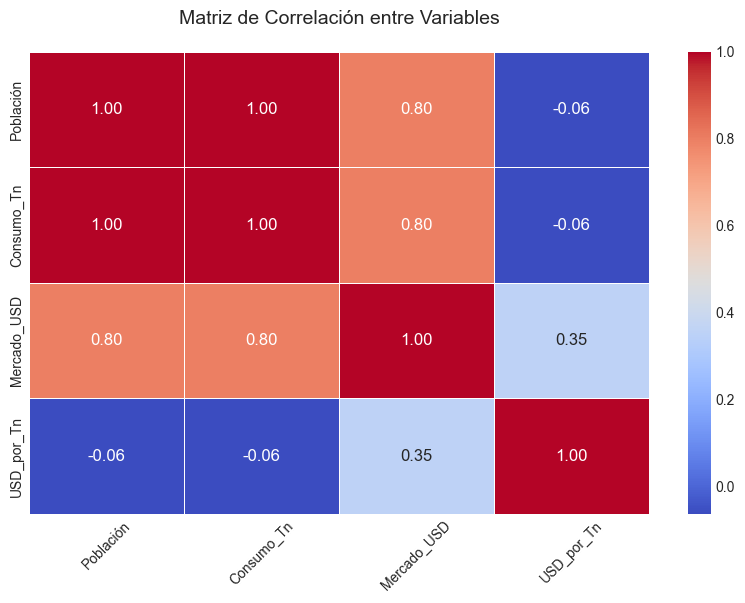

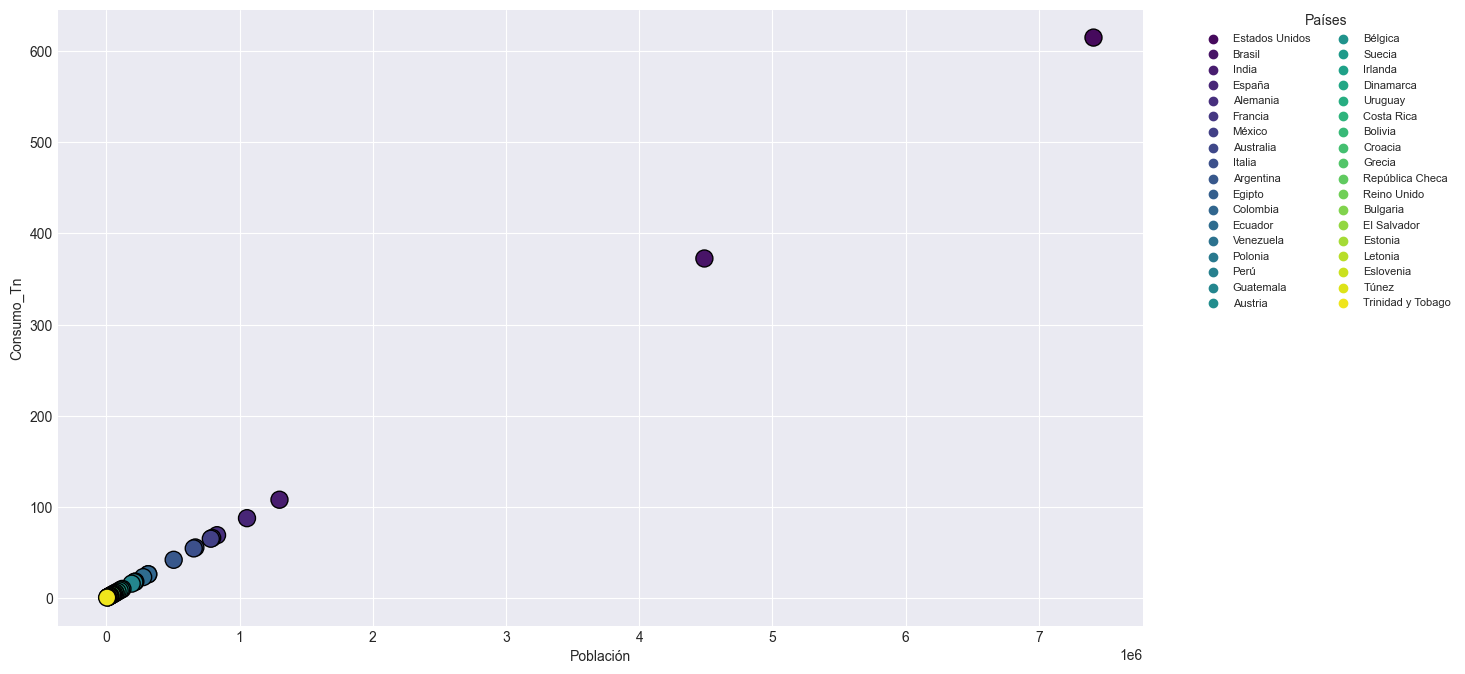

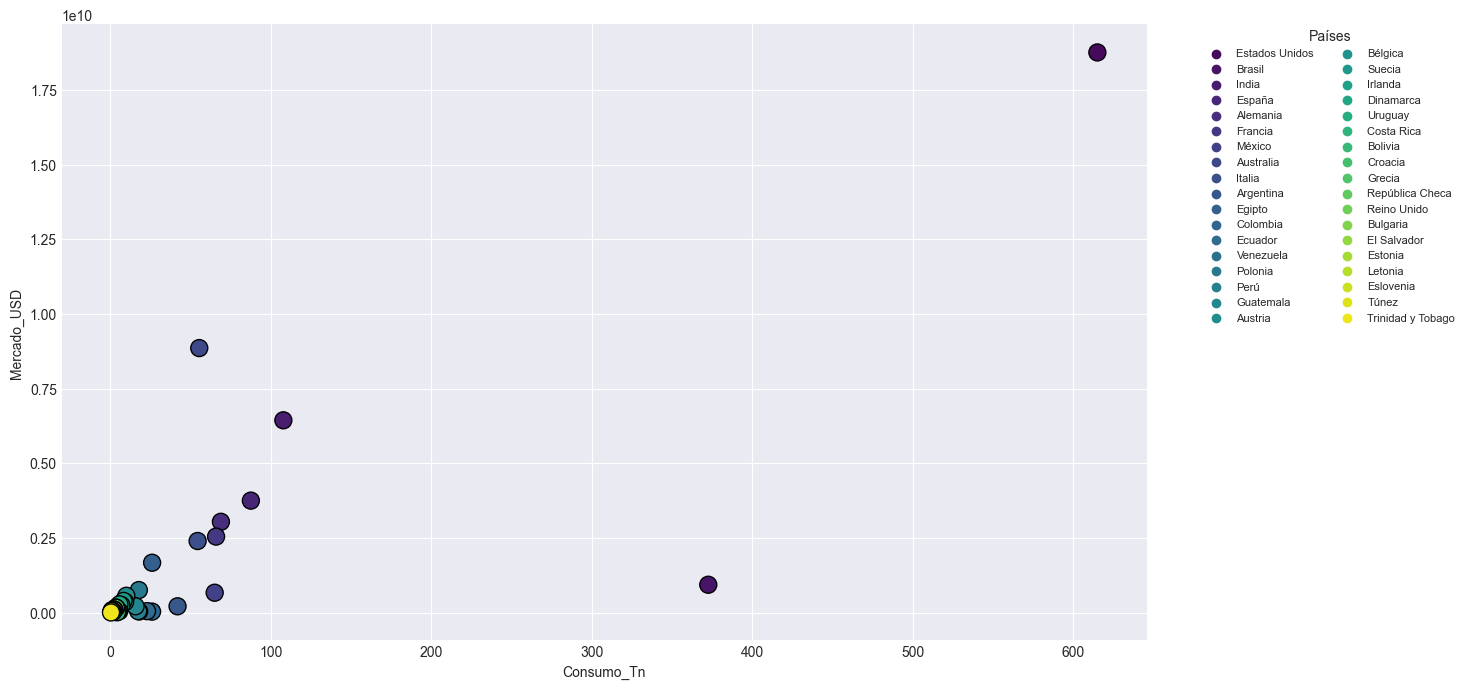

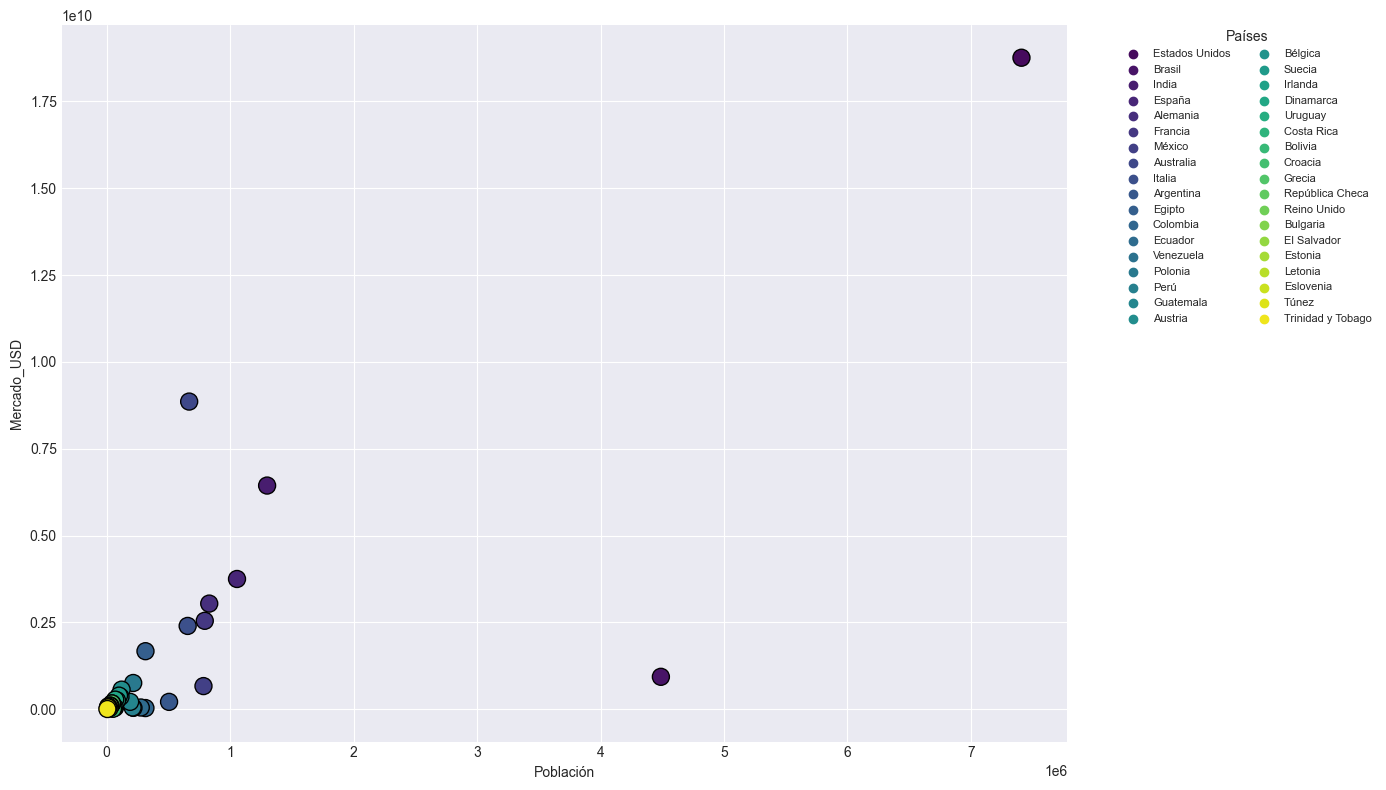

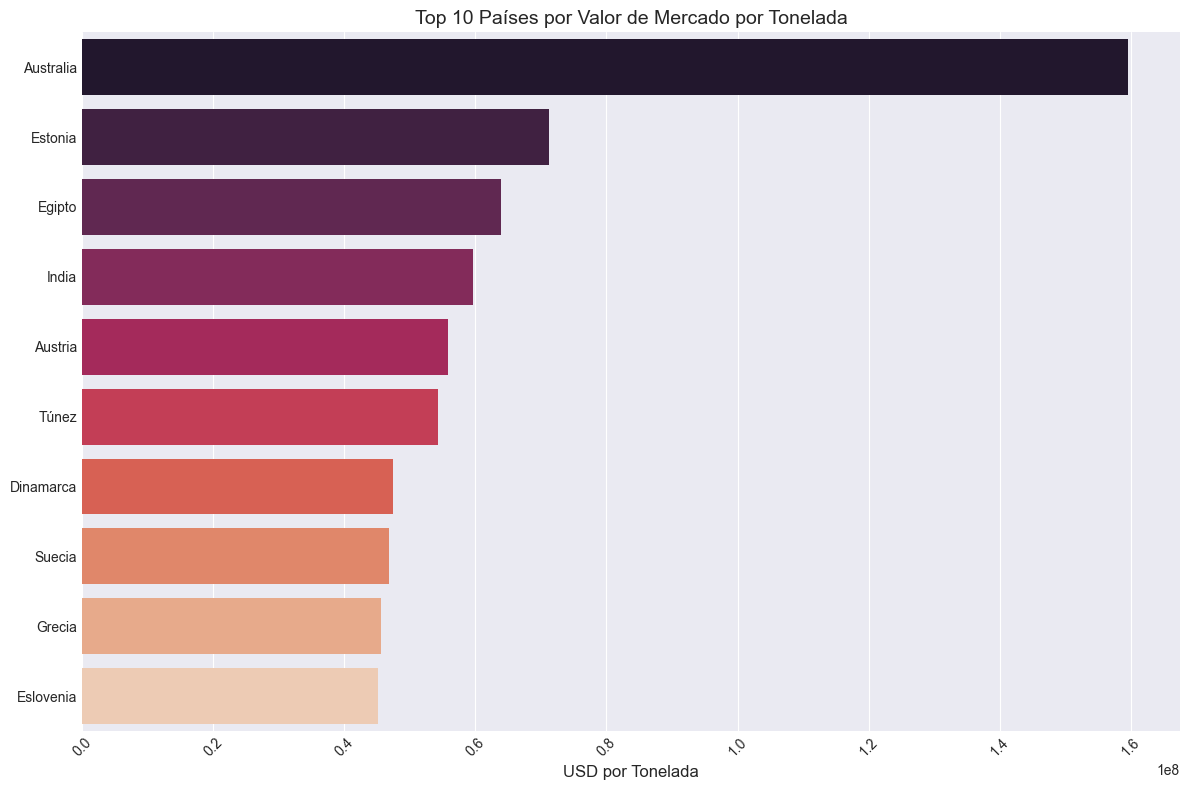

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración de estilo
plt.style.use('seaborn-darkgrid')
palette = sns.color_palette("viridis", n_colors=len(df_mercado))

# 1. Análisis estadístico básico
print("Resumen estadístico:")
print(df_mercado.describe().apply(lambda x: x.apply("{0:.2f}".format)))

# 2. Matriz de correlación
corr_matrix = df_mercado.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            annot_kws={"size":12}, linewidths=0.5)
plt.title("Matriz de Correlación entre Variables", fontsize=14, pad=20)
plt.xticks(rotation=45)
plt.show()

# 3. Scatter Plots con transformación logarítmica
plt.figure(figsize=(14, 8))
ax = sns.scatterplot(data=df_mercado, x='Población', y='Consumo_Tn', 
                    hue='País', palette=palette, s=150, edgecolor='black')


handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, 
          bbox_to_anchor=(1.05, 1),  # Posición fuera del gráfico a la derecha
          loc='upper left', 
          borderaxespad=0.,
          ncol=2,  # Dos columnas
          fontsize=8,  # Tamaño reducido
          title='Países',
          title_fontsize=10,
          frameon=False)

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title("Relación Población vs Consumo (escala logarítmica)", fontsize=12)
axes[0].set_xlabel("Población (log)", fontsize=10)
axes[0].set_ylabel("Consumo en Toneladas (log)", fontsize=10)

# Consumo vs Valor de Mercado
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_mercado, x='Consumo_Tn', y='Mercado_USD', 
                hue='País', palette=palette, s=150, edgecolor='black')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, 
          bbox_to_anchor=(1.05, 1),  # Posición fuera del gráfico a la derecha
          loc='upper left', 
          borderaxespad=0.,
          ncol=2,  # Dos columnas
          fontsize=8,  # Tamaño reducido
          title='Países',
          title_fontsize=10,
          frameon=False)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title("Relación Consumo vs Valor de Mercado (escala logarítmica)", fontsize=12)
axes[1].set_xlabel("Consumo en Toneladas (log)", fontsize=10)
axes[1].set_ylabel("Valor de Mercado USD (log)", fontsize=10)

# Población vs Valor de Mercado
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_mercado, x='Población', y='Mercado_USD', 
                hue='País', palette=palette, s=150, edgecolor='black')

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, 
          bbox_to_anchor=(1.05, 1),  # Posición fuera del gráfico a la derecha
          loc='upper left', 
          borderaxespad=0.,
          ncol=2,  # Dos columnas
          fontsize=8,  # Tamaño reducido
          title='Países',
          title_fontsize=10,
          frameon=False)
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_title("Relación Población vs Valor de Mercado (escala logarítmica)", fontsize=12)
axes[2].set_xlabel("Población (log)", fontsize=10)
axes[2].set_ylabel("Valor de Mercado USD (log)", fontsize=10)

plt.tight_layout()
plt.show()

# 4. Análisis de valor por tonelada
df_mercado['USD_por_Tn'] = df_mercado['Mercado_USD'] / df_mercado['Consumo_Tn']
top_countries = df_mercado.sort_values('USD_por_Tn', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_countries, x='USD_por_Tn', y='País', palette='rocket')
plt.title("Top 10 Países por Valor de Mercado por Tonelada", fontsize=14)
plt.xlabel("USD por Tonelada", fontsize=12)
plt.ylabel("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# DataFrame

In [50]:
df_produccion = df_produccion.rename(columns={'Cocaína': 'Cocaína_produccion',
                              'Opioides': 'Opioides_produccion',
                              'Metanfetaminas': 'Metanfetaminas_produccion',
                              'Categoría_Cocaína':'Categoría_Cocaína_produccion',
                              'Categoría_Opioides':'Categoría_Opioides_produccion',
                              'Categoría_Metanfetaminas':'Categoría_Metanfetaminas_produccion'
                        }
                )

In [51]:
df_consumo = df_consumo.rename(columns={'Cocaína': 'Cocaína_consumo',
                              'Opioides': 'Opioides_consumo',
                              'Metanfetaminas': 'Metanfetaminas_consumo',
                              'Cannabis': 'Cannabis_consumo',
                              'Categoría_Cocaína':'Categoría_Cocaína_consumo',
                              'Categoría_Opioides':'Categoría_Opioides_consumo',
                              'Categoría_Metanfetaminas':'Categoría_Metanfetaminas_consumo'
                        }
                )

In [40]:
df_trafico = df_trafico.rename(columns={'Cocaína': 'Cocaína_trafico',
                              'Heroína': 'Heroína_trafico',
                              'Metanfetaminas': 'Metanfetaminas_trafico',
                              'Cannabis': 'Cannabis_trafico'
                        }
                )

In [ ]:
df_mercado = df_mercado.rename(columns={'Cocaína': 'Cocaína_trafico',
                              'Heroína': 'Heroína_trafico',
                              'Metanfetaminas': 'Metanfetaminas_trafico',
                              'Cannabis': 'Cannabis_trafico'
                        }
                )

In [43]:
df_cultivo = df_cultivo.rename(columns={'Coca': 'Coca_cultivo',
                              'Opio': 'Opio_cultivo'
                        }
                )

In [52]:
# Realizar el merge con sufijos explícitos
df_completo = (
    df_cultivo
    .merge(df_produccion, on='País', how='outer')
    .merge(df_consumo, on='País', how='outer')
    .merge(df_trafico, on='País', how='outer')
    .merge(df_mercado, on='País', how='outer')
)

In [76]:
df_completo.columns

Index(['País', 'Coca_cultivo', 'Opio_cultivo', 'Cocaína_produccion',
       'Categoría_Cocaína_produccion', 'Opioides_produccion',
       'Categoría_Opioides_produccion', 'Metanfetaminas_produccion',
       'Categoría_Metanfetaminas_produccion', 'Cocaína_consumo',
       'Categoría_Cocaína_consumo', 'Cannabis_consumo', 'Categoría_Cannabis',
       'Metanfetaminas_consumo', 'Categoría_Metanfetaminas_consumo',
       'Opioides_consumo', 'Categoría_Opioides_consumo', 'Cocaína_trafico',
       'Cannabis_trafico', 'Metanfetaminas_trafico', 'Heroína_trafico',
       'Población', 'Consumo_Tn', 'Mercado_USD'],
      dtype='object')

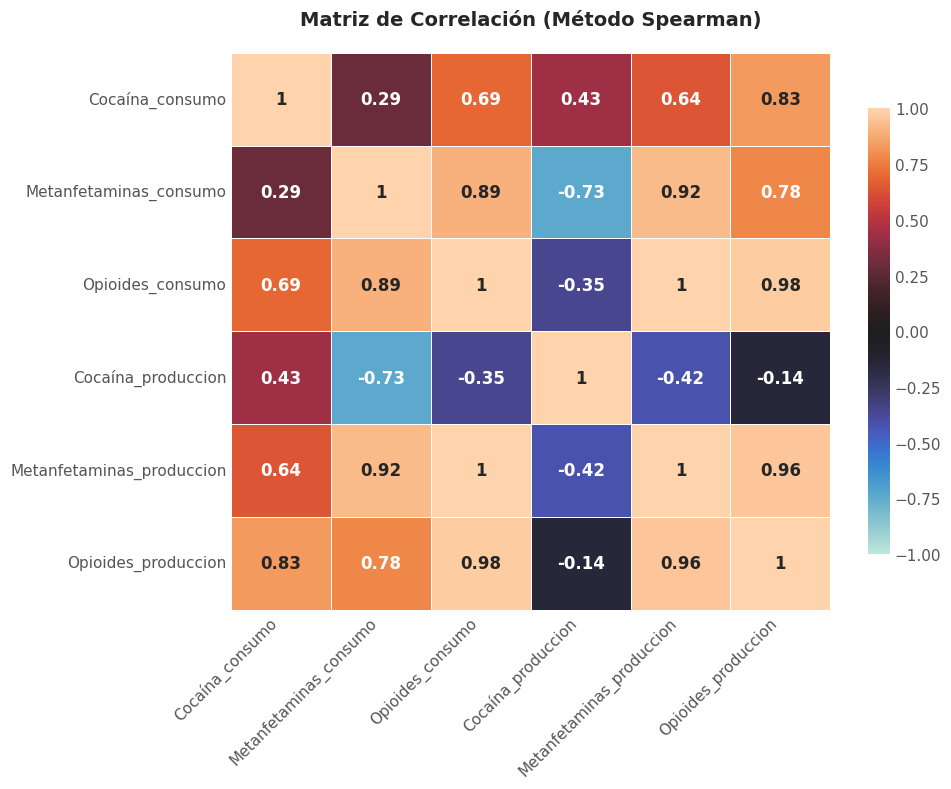

In [79]:
# 2. Matriz de correlación de Pearson (Se puede utilizar Spearman para observar correlaciones no lineales)
# Filtrar y limpiar datos antes de la correlación
df_corr = df_completo[['Cocaína_consumo','Metanfetaminas_consumo', 'Opioides_consumo', 'Cocaína_produccion',
                      'Metanfetaminas_produccion', 'Opioides_produccion' ]]\
            .dropna()\
            .apply(pd.to_numeric, errors='coerce')\
            .corr(method='pearson')  # Usar método no paramétrico

# Visualización mejorada
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, 
           annot=True, 
           cmap='icefire', 
           vmin=-1, vmax=1,
           annot_kws={"size":12, "weight":"bold"},
           linewidths=0.5,
           cbar_kws={"shrink":0.8})

plt.title("Matriz de Correlación (Método Spearman)", 
          fontsize=14, pad=20, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Grafos

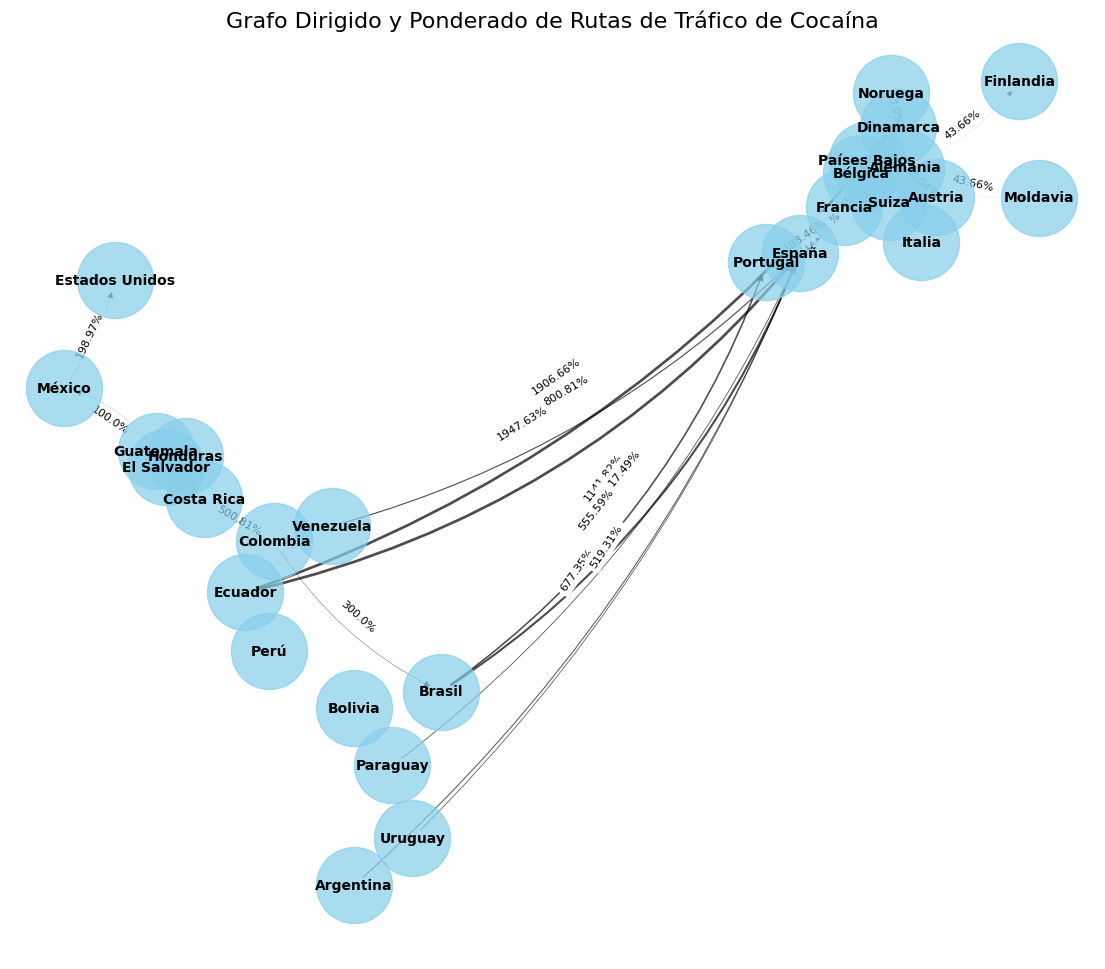

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Diccionario con las coordenadas geográficas de los países (latitud, longitud)
country_coordinates = {
    'Colombia': (4.5709, -74.2973),
    'Perú': (-9.189967, -75.015152),
    'Bolivia': (-16.290154, -63.588653),
    'México': (23.634501, -102.552784),
    'Costa Rica': (9.748917, -83.753428),
    'Guatemala': (15.783471, -90.230759),
    'Honduras': (15.199999, -86.241905),
    'El Salvador': (13.794185, -88.89653),
    'Estados Unidos': (37.09024, -95.712891),
    'Brasil': (-14.235004, -51.92528),
    'Ecuador': (-1.831239, -78.183406),
    'Venezuela': (6.42375, -66.58973),
    'Argentina': (-38.416097, -63.616672),
    'Paraguay': (-23.442503, -58.443832),
    'Uruguay': (-32.522779, -55.765835),
    'España': (40.463667, -3.74922),
    'Portugal': (39.399872, -8.224454),
    'Bélgica': (50.503887, 4.469936),
    'Países Bajos': (52.132633, 5.291266),
    'Alemania': (51.165691, 10.451526),
    'Finlandia': (61.92411, 25.748151),
    'Moldavia': (47.411631, 28.369885),
    'Austria': (47.516231, 14.550072),
    'Noruega': (60.472024, 8.468946),
    'Francia': (46.227638, 2.213749),
    'Italia': (41.87194, 12.56738),
    'Suiza': (46.818188, 8.227512),
    'Dinamarca': (56.26392, 9.501785)
}

# Calcular los rangos de latitudes y longitudes para normalizar
latitudes = [coords[0] for coords in country_coordinates.values()]
longitudes = [coords[1] for coords in country_coordinates.values()]

# Normalización de las latitudes y longitudes
lat_min, lat_max = min(latitudes), max(latitudes)
long_min, long_max = min(longitudes), max(longitudes)

# Función para normalizar las coordenadas
def normalize_latitude(lat):
    return (lat - lat_min) / (lat_max - lat_min)  # Normalizar latitud al rango [0, 1]

def normalize_longitude(lon):
    return (lon - long_min) / (long_max - long_min)  # Normalizar longitud al rango [0, 1]

# Crear el grafo dirigido
G = nx.DiGraph()

# Añadir los nodos con sus coordenadas normalizadas
for country, coords in country_coordinates.items():
    lat, lon = coords
    normalized_lat = normalize_latitude(lat)
    normalized_lon = normalize_longitude(lon)
    G.add_node(country, pos=(normalized_lon, normalized_lat))  # Invertir latitudes para que el norte esté arriba

# Añadir las aristas basadas en las rutas de tráfico y sus ponderaciones (incremento de precio)
rutas_trafico = [
    ('Colombia', 'Costa Rica', 500.81),
    ('Costa Rica', 'Guatemala', 81.97),
    ('Guatemala', 'México', 100.0),
    ('México', 'Estados Unidos', 198.97),
    ('Colombia', 'Brasil', 300.0),
    ('Brasil', 'Portugal', 1141.82),
    ('Brasil', 'España', 1517.49),
    ('Ecuador', 'España', 1947.63),
    ('Ecuador', 'Países Bajos', 1906.66),
    ('Venezuela', 'España', 800.81),
    ('Argentina', 'España', 677.35),
    ('Paraguay', 'España', 555.59),
    ('Uruguay', 'España', 519.31),
    ('Portugal', 'Francia', 188.46),
    ('España', 'Francia', 121.47),
    ('Francia', 'Alemania', 50.0),
    ('Alemania', 'Austria', 20.04),
    ('Alemania', 'Finlandia', 43.66),
    ('Países Bajos', 'Alemania', 30.0),
    ('Bélgica', 'Alemania', 25.0),
    ('Bélgica', 'Francia', 15.0),
    ('Países Bajos', 'Bélgica', 10.0),
    ('Países Bajos', 'Dinamarca', 5.0),
    ('Dinamarca', 'Noruega', 3.0),
    ('Alemania', 'Moldavia', 43.66)
]

for ruta in rutas_trafico:
    G.add_edge(ruta[0], ruta[1], weight=ruta[2])  # Añadir arista con ponderación

# Obtener las posiciones de los nodos (coordenadas normalizadas)
pos = nx.get_node_attributes(G, 'pos')

pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(14, 12))

nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='skyblue', alpha=0.7)

nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

edge_weights = nx.get_edge_attributes(G, 'weight')

for edge, weight in edge_weights.items():
    u, v = edge
    x_values = [pos[u][1], pos[v][1]]  # Longitudes (x)
    y_values = [pos[u][0], pos[v][0]]  # Latitudes (y)

    curvature = 0.1 * np.random.uniform(1, 2)  # Control de la curvatura de las aristas
    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=weight / 1000, alpha=0.7, edge_color='black', style='solid', connectionstyle=f'arc3,rad={curvature}')

edge_labels = {(u, v): f"{d['weight']}%" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Grafo Dirigido y Ponderado de Rutas de Tráfico de Cocaína", fontsize=16)
plt.axis('off')
plt.show()